# Chapter 14. Recurrent Neural Network
  * prediction on data sequence of time series

## Recurrent Neurons
  * Unlike neurons in feed forward network, ouput can be fed into itself
  * not only backpropagation, but also **unrolling** is required during training
  * Memory Cells
    * output from itself of previous time step is called **cell's state**

## Input & Output
  * Sequence to Sequence 
    * e.g. for given time serise input, time series with future prediction are returned 
  * Sequence to Vector (e.g. sentiment analysis) 
  * Vector to Sequence (e.g. captioning image)
  * Encoder - Decoder (e.g. translator) (Seq2Vec - Vec2Seq)


## Recurrent Neuron model

In [49]:
# Basic Model of Recurrent Neuron
import tensorflow as tf
import numpy as np

tf.reset_default_graph()

n_inputs = 3
n_neurons = 5

X0 = tf.placeholder(tf.float32, [None, n_inputs])
X1 = tf.placeholder(tf.float32, [None, n_inputs])

Wx = tf.Variable(tf.random_normal(shape=[n_inputs, n_neurons], dtype=tf.float32))
Wy = tf.Variable(tf.random_normal(shape=[n_neurons, n_neurons], dtype=tf.float32))
b = tf.Variable(tf.zeros([1, n_neurons], dtype=tf.float32))

Y0 = tf.tanh(tf.matmul(X0, Wx) + b)
Y1 = tf.tanh(tf.matmul(Y0, Wy) + tf.matmul(X0, Wx) + b) 
'''
Y2 
Y3
.
.

''' 





[array([[-0.42141908, -0.809767  , -0.14516923,  0.73781574, -0.06028287],
       [ 0.30095518, -0.97897786,  0.07166494,  0.99962914, -0.32041547],
       [ 0.7896704 , -0.99785525,  0.28193057,  0.9999995 , -0.5397935 ],
       [ 0.99673885,  0.5778276 ,  0.67889106,  0.99997693,  0.8691432 ]],
      dtype=float32), array([[ 0.98770326, -0.9142149 ,  0.46105415,  1.        , -0.6597372 ],
       [-0.7081102 ,  0.8166296 , -0.24081503,  0.7314205 , -0.28680807],
       [ 0.6079217 ,  0.08461839,  0.3418136 ,  0.9999945 , -0.7518167 ],
       [ 0.43567273,  0.36083198,  0.8883119 ,  0.9894406 ,  0.1835967 ]],
      dtype=float32)]


## RNN network in simplest form

In [50]:

import tensorflow as tf
import numpy as np

tf.reset_default_graph()

n_inputs = 3
n_neurons = 5
X0 = tf.placeholder(tf.float32, [None, n_inputs])
X1 = tf.placeholder(tf.float32, [None, n_inputs])

basic_cell = tf.contrib.rnn.BasicRNNCell(num_units=n_neurons)
output_seqs, states = tf.contrib.rnn.static_rnn(basic_cell, [X0, X1], dtype=tf.float32)
X0_batch = np.array([[0,1,2],[3,4,5],[6,7,8],[9,0,1]])
X1_batch = np.array([[9,8,7],[0,0,0],[6,5,4],[3,2,1]])

Y0, Y1 = output_seqs
init = tf.global_variables_initializer()

with tf.Session() as sess:
    sess.run(init)
    print(sess.run([Y0,Y1],feed_dict={X0:X0_batch, X1:X1_batch}))
    

[array([[-0.7027918 ,  0.6674094 ,  0.00498064, -0.43444335,  0.6118566 ],
       [-0.99949366,  0.917452  ,  0.98799443, -0.9984121 ,  0.97833204],
       [-0.9999993 ,  0.98158765,  0.9999263 , -0.9999968 ,  0.9990042 ],
       [-0.9997933 ,  0.9314043 ,  0.99996305, -0.99975854,  0.13153642]],
      dtype=float32), array([[-0.99999994,  0.7348813 ,  0.9999998 , -1.        ,  0.9976633 ],
       [ 0.31974855, -0.92133725,  0.25694522, -0.1987123 , -0.8016095 ],
       [-0.9999525 , -0.7069174 ,  0.99995714, -0.99998647,  0.84029955],
       [-0.9760914 , -0.9519193 ,  0.99266493, -0.9831109 ,  0.13102499]],
      dtype=float32)]


## Static Unrolling RNN
- **static_rnn()** -> build unrolled RNN network by chaining RNN cells
- mini batch for RNN
  * each instance of input data is a sequence.. (fixed or variable size)
  * thus, rank of input is 3 (3D) => (batch, steps, inputs)
  * but data should be fed list of steps
    1. transpose(X, perm=[1,0,2]) -> (steps, batch, inputs)
    2. unstack(result from 1) -> (?, inputs)
    * conversion is complex !!!
- static unrolling is memory consuming 
  * each optimization iteration, all tensor values should be stored (because it's recurrent neuron!!)

In [47]:
import tensorflow as tf
import numpy as np

tf.reset_default_graph()

n_steps = 10
n_neurons = 10
n_inputs = 2
n_batch = 10

X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])
X_seqs = tf.transpose(X, perm=[1,0,2])
print(X_seqs.get_shape())
X_seqs_ustk = tf.unstack(X_seqs)
print(X_seqs_ustk[0].get_shape())

basic_cell = tf.contrib.rnn.BasicRNNCell(num_units=n_neurons)
output_seqs, states = tf.contrib.rnn.static_rnn(basic_cell, X_seqs_ustk, dtype=tf.float32)

outputs = tf.transpose(tf.stack(output_seqs), perm=[1,0,2])
x_batch = np.array([[[i for i in range(o, o + n_inputs)] for o in range(n_steps)] for _ in range(n_batch)])
print(x_batch[0])
init = tf.global_variables_initializer()
with tf.Session() as sess:
    sess.run(init)
    print('Input')
    print(sess.run(X, feed_dict={X: [x_batch[0]]}))
    print('After Transpose')
    seqs = sess.run(X_seqs, feed_dict={X: [x_batch[0]]})
    print(type(seqs))
    for l in seqs:
        print(l)
    print('After Unstack')
    seqs_ustk = sess.run(X_seqs_ustk, feed_dict={X: [x_batch[0]]})
    print(type(seqs_ustk))
    for l in seqs_ustk:
        print(l)
    print('Final Data')
    print(sess.run(outputs, feed_dict={X: [x_batch[0]]}))



(10, ?, 2)
(?, 2)
[[ 0  1]
 [ 1  2]
 [ 2  3]
 [ 3  4]
 [ 4  5]
 [ 5  6]
 [ 6  7]
 [ 7  8]
 [ 8  9]
 [ 9 10]]
Input
[[[ 0.  1.]
  [ 1.  2.]
  [ 2.  3.]
  [ 3.  4.]
  [ 4.  5.]
  [ 5.  6.]
  [ 6.  7.]
  [ 7.  8.]
  [ 8.  9.]
  [ 9. 10.]]]
After Transpose
<class 'numpy.ndarray'>
[[0. 1.]]
[[1. 2.]]
[[2. 3.]]
[[3. 4.]]
[[4. 5.]]
[[5. 6.]]
[[6. 7.]]
[[7. 8.]]
[[8. 9.]]
[[ 9. 10.]]
After Unstack
<class 'list'>
[[0. 1.]]
[[1. 2.]]
[[2. 3.]]
[[3. 4.]]
[[4. 5.]]
[[5. 6.]]
[[6. 7.]]
[[7. 8.]]
[[8. 9.]]
[[ 9. 10.]]
Final Data
[[[-0.39882165  0.3542116  -0.07195529 -0.36859003  0.07567247
   -0.02040198  0.46789715  0.2543415   0.23556472 -0.18304275]
  [-0.4633027   0.3413062  -0.7954224  -0.53963345  0.18950076
    0.09189894  0.5788722   0.37592298  0.41902596 -0.14458562]
  [-0.7979515   0.3925388  -0.94819856 -0.7438859   0.53125167
    0.37850165  0.7288936   0.796322    0.78594965 -0.06165339]
  [-0.9072312  -0.03132254 -0.9926383  -0.7012744   0.7915995
    0.17497925  0.8695304   0.901851

## Dynamic Unrolling
 * support swapping memory contents CPU <-> GPU
   * prevent OOM
   * no need for tensor conversion 


In [3]:
import tensorflow as tf
import numpy as np
tf.reset_default_graph()

n_steps = 10
n_neurons = 10
n_inputs = 20
n_batch = 1

X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])
x_batch = np.array([[[i for i in range(o, o + n_inputs)] for o in range(n_steps)] for _ in range(n_batch)])

basic_cell = tf.contrib.rnn.BasicRNNCell(n_neurons)
outputs, states = tf.nn.dynamic_rnn(basic_cell, X, dtype=tf.float32)
init = tf.global_variables_initializer()

with tf.Session() as sess:
    sess.run(init)
    print(sess.run(outputs, feed_dict={X:x_batch}))
    print(sess.run(states, feed_dict={X:x_batch}))
    

[[[-0.99999946  0.99985343 -1.         -0.99999964 -1.
    1.          0.99250716  0.9989012   1.         -1.        ]
  [-0.99999946  0.9999933  -1.         -0.99999994 -1.
    1.          0.9988802   0.9998066   1.         -1.        ]
  [-0.99999946  0.9999966  -1.         -1.         -1.
    1.          0.9997861   0.99981034  1.         -1.        ]
  [-0.99999946  0.9999983  -1.         -1.         -1.
    1.          0.9999591   0.9998136   1.         -1.        ]
  [-0.9999995   0.9999991  -1.         -1.         -1.
    1.          0.9999922   0.9998168   1.         -1.        ]
  [-0.9999995   0.9999996  -1.         -1.         -1.
    1.          0.9999985   0.9998199   1.         -1.        ]
  [-0.9999996   0.99999976 -1.         -1.         -1.
    1.          0.9999997   0.9998229   1.         -1.        ]
  [-0.9999996   0.9999999  -1.         -1.         -1.
    1.          0.99999994  0.9998259   1.         -1.        ]
  [-0.9999996   0.99999994 -1.         -1.      

In [19]:
import tensorflow as tf
import numpy as np
from sklearn.datasets import load_digits
from sklearn.model_selection import StratifiedShuffleSplit
import pandas as pd
import collections

class SimpleBatch(collections.Iterator):
    def __init__(self, data, labels, size):
        self.data = data
        self.labels = labels
        self.size = size 
        self.pos = 0
    
    def __iter__(self):
        self.pos = 0
        return self
        
    def __next__(self):
        if self.pos < len(self.data):
            self.pos += 1
            return self.data[self.pos: self.pos + self.size], self.labels[self.pos: self.pos + self.size]
        raise StopIteration
        

tf.reset_default_graph()
digits_raw = load_digits()
learning_rate = 0.001
n_epoch = 20

data = digits_raw.data
n_input = int(np.sqrt(data.shape[1]))
n_step = int(np.sqrt(data.shape[1]))
batch_size = 30

data = data.reshape((-1, n_step, n_input))
print(data.shape)

labels = digits_raw.target

sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2)

for train_indices, test_indices in sss.split(data, labels):
    train_data, test_data = data[train_indices], data[test_indices]
    train_labels, test_labels = labels[train_indices], labels[test_indices]
    

X = tf.placeholder(dtype=tf.float32, shape=(None, n_step, n_input))
Y = tf.placeholder(dtype=tf.int32, shape=(None))

basic_cell = tf.contrib.rnn.BasicRNNCell(100)
Y_seqs, states = tf.nn.dynamic_rnn(basic_cell, X, dtype=tf.float32)
logits = tf.keras.layers.Dense(10, name="output")(states)

xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=Y, logits=logits)
loss = tf.reduce_mean(xentropy)
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
train_op = optimizer.minimize(loss)
correct = tf.nn.in_top_k(logits, Y, 1)
accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

from datetime import datetime

init = tf.global_variables_initializer()
saver = tf.train.Saver()
summary_writer = tf.summary.FileWriter('/home/tf_logs/rnn_mnist_{}_{}_{}'.format(datetime.now().strftime("%Y%m%d_%H%M%S"), 
                                                                batch_size, 
                                                                n_epoch), graph=tf.get_default_graph())

with tf.Session() as sess:
    sess.run(init)
    batches = len(train_data) / batch_size
    simple_batch = SimpleBatch(train_data, train_labels, batch_size)
    for epoch in range(n_epoch):
        for data, labels in iter(simple_batch):
            sess.run(train_op, feed_dict={X: data, Y: labels})            
        y_pred = sess.run(logits, feed_dict={X: test_data})
        xe = sess.run(xentropy, feed_dict={logits: y_pred, Y: test_labels})
        summary = tf.summary.Summary()
        ls = sess.run(loss, feed_dict={xentropy: xe})
        summary.value.add(tag="test_loss", simple_value=ls)
        summary.value.add(tag='test_acc', simple_value=sess.run(accuracy, feed_dict={X: test_data, Y: test_labels}))
        summary.value.add(tag='train_acc', simple_value=sess.run(accuracy, feed_dict={X: train_data, Y: train_labels}))
        summary_writer.add_summary(summary, epoch * batches)
    saver.save(sess, '/home/tf_logs/rnn_mnist_{}_{}_{}'.format(datetime.now().strftime("%Y%m%d_%H%M%S"), 
                                                                batch_size, 
                                                                n_epoch))

summary_writer.close()



(1797, 8, 8)


## Predicting Time Series
* simplest solution -> using TF OutputProjectionWrapper
* more advanced approach -> Fully Connected layer over the top of RNN


### Playing with RNN on the real world data (stock prices)

In [65]:
import investpy as iv

counties = iv.get_stock_countries()
cur_history = iv.get_currency_cross_historical_data(currency_cross='USD/KRW',from_date='01/01/2019',to_date='31/12/2020')

sm_stk_history = iv.get_stock_historical_data(stock='005930',country='south korea', from_date='01/01/2019', to_date='31/12/2020')
sm_stk_history = sm_stk_history.drop(columns=['Currency'])
sm_stk_history = sm_stk_history.astype(float)
sm_stk_history /= 100



,RS_15,LOSS_15,GAIN_15,RSI_15,Volume,CUR_CROSS,Median,SMA_5,SMA_20,SMA_60,SMA_120,MGAP,labels
RS_15,1.000000,0.408004,0.365341,0.929182,0.073451,0.003949,0.059664,0.053196,0.007730,0.004490,0.026598,-0.002909,0.267706
LOSS_15,0.408004,1.000000,-0.601551,0.370810,-0.157748,-0.376399,-0.200355,-0.212278,-0.294397,-0.445425,-0.432015,-0.036567,-0.480321
GAIN_15,0.365341,-0.601551,1.000000,0.469164,0.295354,0.375666,0.281871,0.281227,0.322334,0.489310,0.514142,0.028109,0.752543
RSI_15,0.929182,0.370810,0.469164,1.000000,0.131040,0.060065,0.070360,0.063445,0.022235,0.033659,0.082513,0.006639,0.344611
Volume,0.073451,-0.157748,0.295354,0.131040,1.000000,0.353005,-0.138233,-0.106429,-0.045057,0.092312,0.073142,-0.005670,0.252442
CUR_CROSS,0.003949,-0.376399,0.375666,0.060065,0.353005,1.000000,-0.182196,-0.150484,-0.029236,0.168873,0.217826,0.140869,0.455371
Median,0.059664,-0.200355,0.281871,0.070360,-0.138233,-0.182196,1.000000,0.989801,0.949097,0.841359,0.734161,-0.044902,0.315649
SMA_5,0.053196,-0.212278,0.281227,0.063445,-0.106429,-0.150484,0.989801,1.000000,0.967254,0.859923,0.747833,-0.020469,0.329198
SMA_20,0.007730,-0.294397,0.322334,0.022235,-0.045057,-0.029236,0.949097,0.967254,1.000000,0.922132,0.799997,-0.022088,0.401772
SMA_60,0.004490,-0.445425,0.489310,0.033659,0.092312,0.168873,0.841359,0.859923,0.922132,1.000000,0.917965,-0.005067,0.533174


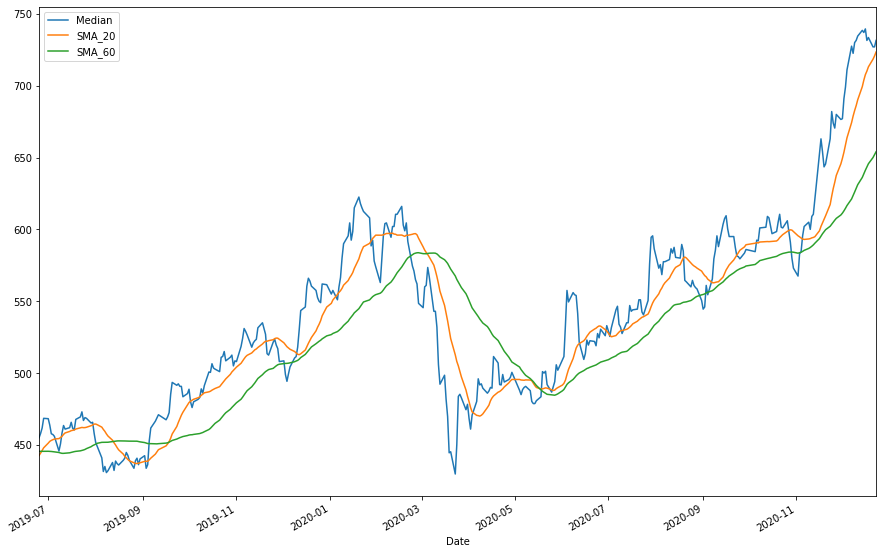

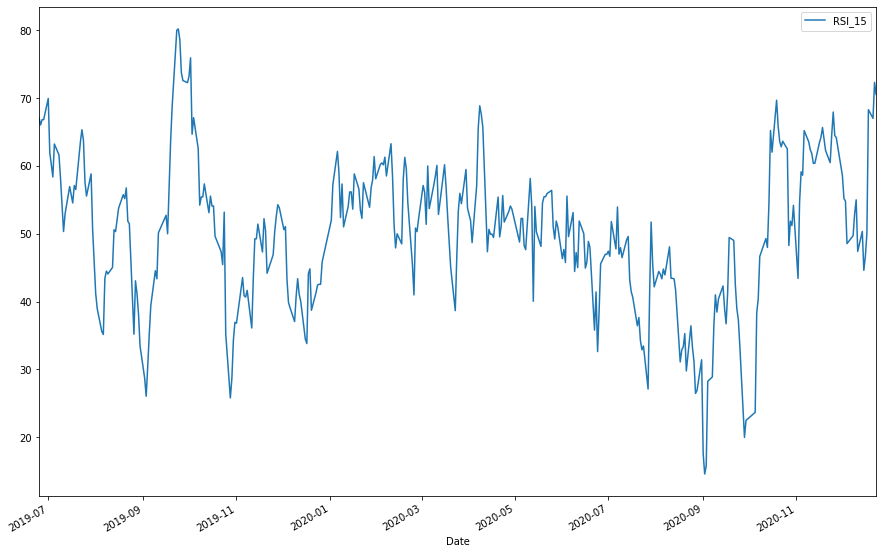

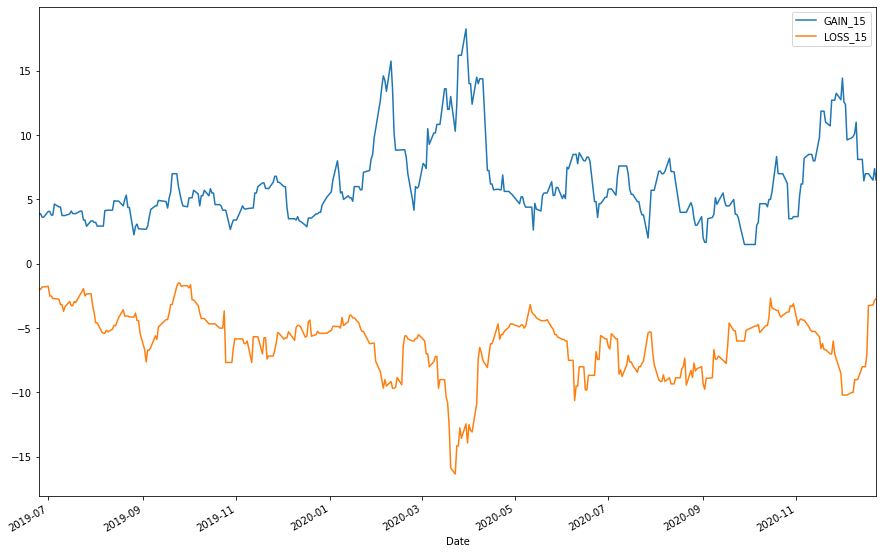

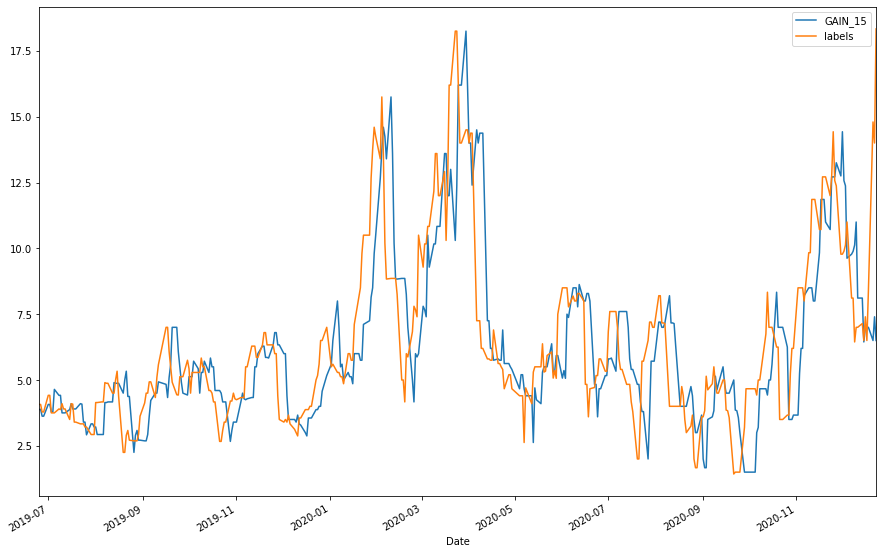

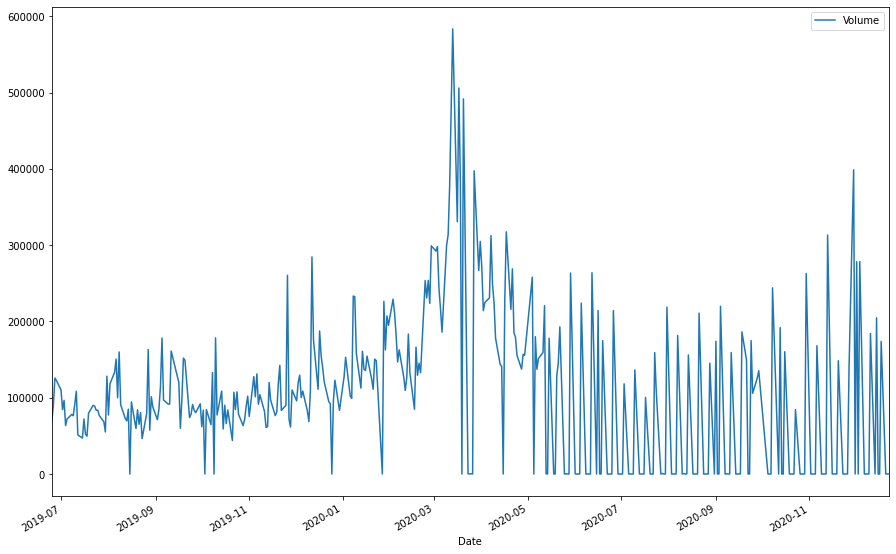

In [85]:
import collections
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pandas.plotting import scatter_matrix

ext_stock_history = sm_stk_history.copy()
ext_stock_history['CUR_CROSS'] = (cur_history['High'] - cur_history['Low']) / 2000

## data preparation 
SMA_WINDOWS = [5,20,60,120]
ext_stock_history['Median'] = (ext_stock_history['High'] + ext_stock_history['Low']) / 2

for wnd in SMA_WINDOWS:
    ext_stock_history['SMA_{}'.format(wnd)] = ext_stock_history['Median'].rolling(window=wnd).mean()

ext_stock_history['MGAP'] = (ext_stock_history['Open'][1:] - ext_stock_history['Close'][:-1]) / ext_stock_history['Close'][:-1]
def chop_seq(data, step_sz):
    trunc_sz = int(np.floor(len(data) / step_sz) - 1) * step_sz
    return [data[i:i + step_sz] for i in range(trunc_sz)]

def calc_rsi(data, period):
    keys = ['RSI_{}'.format(period), 
            'GAIN_{}'.format(period), 
            'LOSS_{}'.format(period),
            'RS_{}'.format(period)]

    open_close_price = data[['Open','Close']].to_numpy()
    gain, loss, rs_v, rsi_v = [], [], [], []
    truncated = open_close_price[:-period]
    for i, _ in enumerate(truncated):
        change = open_close_price[i : i + period][:,1] - open_close_price[i: i + period][:,0]
        avg_g = np.average(change[change > 0])
        avg_l = np.average(change[change < 0])
        rs = avg_g / np.abs(avg_l)
        rsi = 100 - 100 / (1 + rs)
        
        gain.append(avg_g)
        loss.append(avg_l)
        rs_v.append(rs)
        rsi_v.append(rsi)
    padding = [None for _ in range(period)]
    return dict(zip(keys, np.array([np.array(padding + rsi_v), np.array(padding + gain), np.array(padding + loss), np.array(padding + rs_v)], dtype=float)))

rsi_window = 15
prediction_offset = 5
prediction_target = 'GAIN_15'
n_steps = 20

rsi_data = calc_rsi(sm_stk_history, rsi_window)
for k in rsi_data:
    ext_stock_history.insert(0, k, rsi_data[k])

ext_stock_history['labels'] = np.append(ext_stock_history[prediction_target][prediction_offset:].to_numpy(), [None for _ in range(prediction_offset)]).astype(float)

# sm_stk_history = sm_stk_history[sm_stk_history['Volume'] > 1000]
clean_stock = ext_stock_history.dropna()
clean_stock = clean_stock.drop(columns=['Open', 'High', 'Low', 'Close'], axis=1)
# input_features = ['Median', 'Volume', rsi_key, 'Close', 'Open']
input_features = ['SMA_120', 'SMA_60','SMA_20', 'CUR_CROSS', 'LOSS_15']


stock_data = np.array(chop_seq(clean_stock[input_features].to_numpy(), n_steps))
refs = np.array(chop_seq(clean_stock[prediction_target].to_numpy(), n_steps))
labels = np.array(chop_seq(clean_stock['labels'].to_numpy(), n_steps))

clean_stock.plot(y=['Median','SMA_20', 'SMA_60'],figsize=(15,10))
clean_stock.plot(y=[rsi_key],figsize=(15,10))
clean_stock.plot(y=[gain_key, loss_key], figsize=(15,10))
clean_stock.plot(y=[prediction_target, 'labels'], figsize=(15,10))
clean_stock.plot(y=['Volume'], figsize=(15,10))
clean_stock = clean_stock.copy()
clean_stock.corr()

# scatter_matrix(clean_stock, figsize=(15,10))


In [86]:
import tensorflow as tf
import sys
import collections
import numpy as np
from datetime import datetime

class SimpleBatch(collections.Iterator):
    def __init__(self, data, labels, size, normalize=False):
        self.data = data
        self.labels = labels
        self.size = size 
        self.pos = 0
        self.normalize = normalize
    
    def __iter__(self):
        self.pos = 0
        return self
        
    def __next__(self):
        if self.pos + self.size < len(self.data):
            self.pos += 1
            data, labels = self.data[self.pos: self.pos + self.size], self.labels[self.pos: self.pos + self.size]
            if self.normalize:
                return data / np.max(data), labels
            else:
                return data, labels
        raise StopIteration
        

tf.reset_default_graph()

n_inputs = len(input_features)
batch_size = 10
n_neurons = 40
n_layers = 4
n_outputs = 1
n_epoch = 500
learning_rate = 1e-6


sbatch = SimpleBatch(stock_data, labels, batch_size, normalize=False)

X = tf.placeholder(dtype=tf.float32, shape=(None, n_steps, n_inputs))
Y = tf.placeholder(dtype=tf.float32, shape=(None))

# ml_cells = tf.contrib.cudnn_rnn.CudnnLSTM(num_units=n_neurons, num_layers=3)
cells = [tf.contrib.rnn.BasicRNNCell(n_neurons, activation=tf.nn.leaky_relu) for i in range(n_layers)]
dropout_cells = [tf.contrib.rnn.DropoutWrapper(cell, input_keep_prob=0.5, state_keep_prob=0.7) for cell in cells]
ml_cells = tf.contrib.rnn.MultiRNNCell(cells)
rnn_outputs, states = tf.nn.dynamic_rnn(ml_cells, X, dtype=tf.float32)

stacked_rnn_out = tf.reshape(rnn_outputs, shape=(-1, n_neurons))
serialized = tf.keras.layers.Dense(1)(stacked_rnn_out)
output = tf.reshape(serialized, [-1, n_steps])


loss = tf.reduce_mean(tf.square(Y - output))
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(loss)

init = tf.global_variables_initializer()
saver = tf.train.Saver()
summary_writer = tf.summary.FileWriter('/home/tf_logs/rnn_stock_{}_{}_{}'.format(datetime.now().strftime("%Y%m%d_%H%M%S"), 
                                                                 batch_size,
                                                                 n_neurons), graph=tf.get_default_graph())


min_loss = sys.maxsize
with tf.Session() as sess:
    sess.run(init)
    ref_loss = sess.run(loss, feed_dict={output:refs, Y: labels})
    print(ref_loss)
    for epoch in range(n_epoch):
        for b_data, b_labels in iter(sbatch):
            sess.run(training_op, feed_dict={X: b_data, Y: b_labels})            
        summary = tf.summary.Summary()
        pred_prices = sess.run(output,feed_dict={X:stock_data})
        test_loss = sess.run(loss, feed_dict={output:pred_prices, Y:labels})
        if min_loss > test_loss:
            min_loss = test_loss
            saver.save(sess, '/home/tf_logs/rnn_stock_v0.ckpt')
        summary.value.add(tag="test_loss", simple_value=test_loss)
        summary_writer.add_summary(summary, epoch)
        print(epoch, test_loss, min_loss)
    summary_writer.close()

4.590179
0 1965.552 1965.552
1 884.75525 884.75525
2 433.51038 433.51038
3 307.7654 307.7654
4 262.06604 262.06604
5 230.3769 230.3769
6 204.82556 204.82556
7 181.94594 181.94594
8 160.7871 160.7871
9 141.32185 141.32185
10 124.199394 124.199394
11 109.56078 109.56078
12 96.81169 96.81169
13 85.10893 85.10893
14 74.58659 74.58659
15 65.20729 65.20729
16 56.96422 56.96422
17 49.753716 49.753716
18 43.39453 43.39453
19 37.80157 37.80157
20 32.93341 32.93341
21 28.711857 28.711857
22 25.054592 25.054592
23 21.989384 21.989384
24 19.508806 19.508806
25 17.402615 17.402615
26 15.618086 15.618086
27 14.139893 14.139893
28 12.931517 12.931517
29 11.962021 11.962021
30 11.192819 11.192819
31 10.589157 10.589157
32 10.121017 10.121017
33 9.761221 9.761221
34 9.489733 9.489733
35 9.291064 9.291064
36 9.145837 9.145837
37 9.038475 9.038475
38 8.958931 8.958931
39 8.900361 8.900361
40 8.855866 8.855866
41 8.821325 8.821325
42 8.794223 8.794223
43 8.772678 8.772678
44 8.75505 8.75505
45 8.7404785 8

KeyboardInterrupt: 

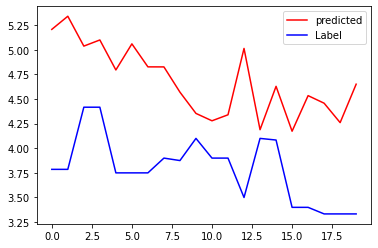

In [88]:
import matplotlib.pyplot as plt 

# plt.plot(stock_data[2][:,0], c='g', label='Input')
plt.plot(pred_prices[2],c='r', label='predicted')
plt.plot(labels[2],c='b',label='Label')
plt.legend()
plt.show()



In [48]:
import numpy as np
import matplotlib.pyplot as plt
import collections

def make_sin(n_sample, cycle=1):
    pos = np.array([np.sin(2 * i * np.pi * cycle / (n_sample)) for i in range(n_sample)]) + 1 
    return pos / 2

def chop_seq(seq, step_sz):
    return [seq[i:i + step_sz] for i in range(len(seq) - step_sz)]

class SimpleBatch(collections.Iterator):
    def __init__(self, data, labels, size):
        self.data = data
        self.labels = labels
        self.size = size 
        self.pos = 0
    
    def __iter__(self):
        self.pos = 0
        return self
        
    def __next__(self):
        if self.pos < len(self.data) - self.size:
            self.pos += 1
            return self.data[self.pos: self.pos + self.size], self.labels[self.pos: self.pos + self.size]
        raise StopIteration


n_sample = 1000
# raw = make_sin(n_sample, 4) + make_sin(n_sample, 8) + make_sin(n_sample, 12) + make_sin(n_sample, 16) + make_sin(n_sample, 2)
raw = make_sin(n_sample, 25)




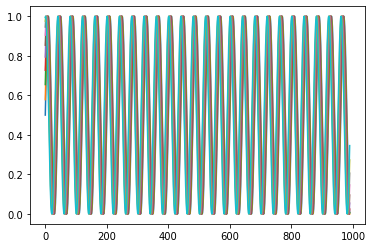

(?, 10, 10)
(?, 10, 50)
model saved @ 0.3357662558555603
0.3357662558555603 @ 0
model saved @ 0.23711425065994263
0.23711425065994263 @ 1
model saved @ 0.14587391912937164
0.14587391912937164 @ 2
model saved @ 0.10213755071163177
0.10213755071163177 @ 3
model saved @ 0.08260215073823929
0.08260215073823929 @ 4
model saved @ 0.06831356883049011
0.06831356883049011 @ 5
model saved @ 0.05585084855556488
0.05585084855556488 @ 6
model saved @ 0.046991296112537384
0.046991296112537384 @ 7
model saved @ 0.040078841149806976
0.040078841149806976 @ 8
model saved @ 0.03255428746342659
0.03255428746342659 @ 9
model saved @ 0.026677122339606285
0.026677122339606285 @ 10
model saved @ 0.022272853180766106
0.022272853180766106 @ 11
model saved @ 0.019207734614610672
0.019207734614610672 @ 12
model saved @ 0.016718193888664246
0.016718193888664246 @ 13
model saved @ 0.01474610436707735
0.01474610436707735 @ 14
model saved @ 0.013117379508912563
0.013117379508912563 @ 15
model saved @ 0.01172328740358

In [56]:
import tensorflow as tf
from datetime import datetime
import sys
from sklearn.model_selection import StratifiedShuffleSplit

n_inputs = 1
n_steps = 10
n_neurons = 50
n_layers = 3
batch_size = 10
n_epochs = 50
n_fold = 10

learning_rate = 0.000005
prediction_offset = 5
keep_prob = 0.5

tf.reset_default_graph()
# data preparation
data = np.array(chop_seq(raw, n_steps))
b_data = np.array([[i] for i in data])
b_data = b_data.transpose((0,2,1))
labels = b_data[prediction_offset:]
b_data = b_data[:-prediction_offset]

b_train_len = 800
b_test_len = int(len(b_data) - b_train_len)
sss = StratifiedShuffleSplit(n_splits=n_epochs, test_size=0.2)

    
sb = SimpleBatch(train_data, train_labels, batch_size)
plt.plot(data)
plt.show()


X = tf.placeholder(tf.float32, shape=(None,n_steps, n_inputs))
Y = tf.placeholder(tf.float32, shape=(None,n_steps, n_inputs))

# conv_1 = tf.keras.layers.Conv1D(5, 1, activation="relu", padding="same")(X)
# conv_2 = tf.keras.layers.Conv1D(5, 3, activation="relu", padding="same")(X)

# concatenated = tf.keras.layers.concatenate([conv_1, conv_2], axis= -1)
# conv_out = tf.keras.layers.Dropout(keep_prob)(concatenated)


print(conv_out.get_shape())
cells = [tf.contrib.rnn.BasicRNNCell(n_neurons, activation=tf.nn.relu) for layer in range(n_layers)]
cells_drop = [tf.contrib.rnn.DropoutWrapper(cell, input_keep_prob=keep_prob) for cell in cells]
multi_layer_cell = tf.contrib.rnn.MultiRNNCell(cells)
outputs, states = tf.nn.dynamic_rnn(multi_layer_cell, X, dtype=tf.float32)
flatten = tf.reshape(outputs, (-1, n_neurons))
serialized = tf.keras.layers.Dense(1)(flatten)
print(outputs.get_shape())
pred = tf.reshape(serialized, (-1, n_steps, n_inputs))

loss = tf.reduce_mean(tf.square(Y - pred))
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
train_op = optimizer.minimize(loss)

init = tf.global_variables_initializer()
saver = tf.train.Saver()

with tf.Session() as sess:
    sess.run(init)
    min_loss = sys.maxsize
    for epoch in range(n_epochs):
        for sample in iter(sb):
            sess.run(train_op, feed_dict={X: sample[0], Y: sample[1]})
        loss_val = sess.run(loss, feed_dict={X:test_data, Y: test_labels})
        if loss_val < min_loss:
            min_loss = loss_val         
            print('model saved @ {}'.format(loss_val))
            saver.save(sess, '/home/tf_logs/rnn_sin_{}_{}_{}.ckpt'.format(datetime.now().strftime("%Y%m%d"), 
                                                                          batch_size, 
                                                                          n_neurons, 
                                                                          n_fold))
        print('{} @ {}'.format(loss_val, epoch))
    pred_test = sess.run(pred, feed_dict={X:test_data})
       


INFO:tensorflow:Restoring parameters from /home/tf_logs/rnn_sin_20210106_10_50.ckpt


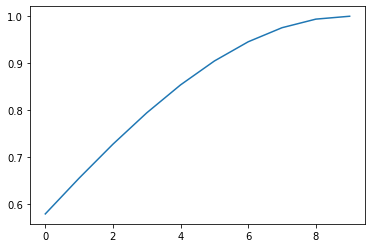

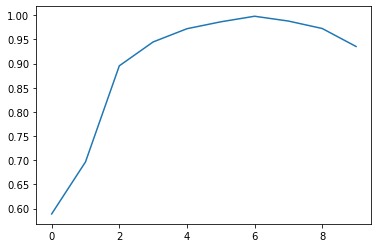

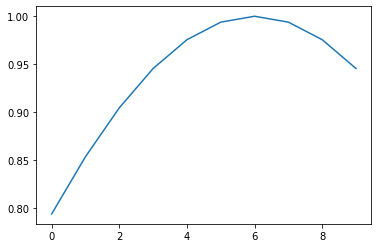

In [57]:

saver = tf.train.Saver()

with tf.Session() as sess:
    saver.restore(sess, '/home/tf_logs/rnn_sin_{}_{}_{}.ckpt'.format(datetime.now().strftime("%Y%m%d"), 
                                                                          batch_size, 
                                                                          n_neurons, 
                                                                          n_fold))
    pred_test = sess.run(pred, feed_dict={X:test_data})

pred_c = np.transpose(pred_test, (0,2,1))
label_c = np.transpose(test_labels, (0,2,1))
in_c = np.transpose(test_data, (0,2,1))
pred_c = np.array([i[0] for i in pred_c])
label_c = np.array([i[0] for i in label_c])
in_c = np.array([i[0] for i in in_c])

plt.plot(in_c[1])
plt.show()

plt.plot(pred_c[1])
plt.show()

plt.plot(label_c[1])
plt.show()



(800, 10, 1)
(800, 10, 1)


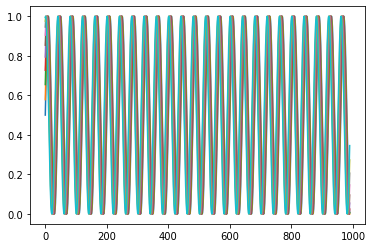

0.21498385
0.1370472
0.105149575
0.08711576
0.07191485
0.05938693
0.048958827
0.041792784
0.03595031
0.0305359
0.026269712
0.022991318
0.020362278
0.018195719
0.016319402
0.014751198
0.013431749
0.012310758
0.011330602
0.010467935
0.009721667
0.009091513
0.0085907485
0.008155116
0.007723718
0.0073502245
0.0070298966
0.006738823
0.006460175
0.0061981743
0.005978776
0.005773963
0.005602708
0.0054620802
0.0053391405
0.0052216025
0.0051080044
0.005004361
0.0049086027
0.0048170215
0.004732493
0.004655984
0.00458073
0.0045106937
0.0044463663
0.004384079
0.004330565
0.0042787823
0.004231416
0.0041883546
0.0041466993
0.004106595
0.0040664226
0.004027628
0.0039885836
0.0039490904
0.0039129327
0.0038716556
0.0038353424
0.003793263
0.0037521722
0.003712697
0.0036764203
0.003646805
0.0036191666
0.003592205
0.003566433
0.0035403827
0.0035174454
0.0034935123
0.0034703845
0.0034486607
0.003426944
0.003405179
0.0033846116
0.0033632657
0.0033425745
0.0033224185
0.0033027895
0.003283213
0.0032631003
0.0

KeyboardInterrupt: 

In [52]:
import tensorflow as tf
from sklearn.model_selection import StratifiedShuffleSplit

n_inputs = 1
n_steps = 10
n_neurons = 50 
n_layers = 2
batch_size = 10
n_epochs = 100

learning_rate = 0.000005
prediction_offset = 3
keep_prob = 0.5

tf.reset_default_graph()
# data preparation
data = np.array(chop_seq(raw, n_steps))
b_data = np.array([[i] for i in data])
b_data = b_data.transpose((0,2,1))
labels = b_data[prediction_offset:]
b_data = b_data[:-prediction_offset]

b_train_len = 800
b_test_len = int(len(b_data) - b_train_len)
train_data, test_data = b_data[:b_train_len], b_data[-b_test_len:]
train_labels, test_labels = labels[:b_train_len], labels[-b_test_len:]
print(train_labels.shape)
print(train_data.shape)
    
sb = SimpleBatch(train_data, train_labels, batch_size)
plt.plot(data)
plt.show()


X = tf.placeholder(tf.float32, shape=(None,n_steps,n_inputs))
Y = tf.placeholder(tf.float32, shape=(None,n_steps, n_inputs))

cells = [tf.contrib.rnn.BasicRNNCell(n_neurons, activation=tf.nn.relu) for layer in range(n_layers)]
cells_drop = [tf.contrib.rnn.DropoutWrapper(cell, input_keep_prob=keep_prob) for cell in cells]
multi_layer_cell = tf.contrib.rnn.MultiRNNCell(cells)
outputs, states = tf.nn.dynamic_rnn(multi_layer_cell, X, dtype=tf.float32)
flatten = tf.reshape(outputs, (-1, n_neurons))
serialized = tf.keras.layers.Dense(1)(flatten)
pred = tf.reshape(serialized, (-1, n_steps, n_inputs))

loss = tf.reduce_mean(tf.square(Y - pred))
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
train_op = optimizer.minimize(loss)

init = tf.global_variables_initializer()

with tf.Session() as sess:
    sess.run(init)
    for epoch in range(n_epochs):
        for sample in iter(sb):
            sess.run(train_op, feed_dict={X: sample[0], Y: sample[1]})
        print(sess.run(loss, feed_dict={X:test_data, Y: test_labels}))
    pred_test = sess.run(pred, feed_dict={X:test_data})
    

        
